<h1 style="font-size:3rem;color:maroon;"> Predicting Air Pollution Level using Machine Learning</h1>

This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting air pollution level in an area in Eindhoven in the upcoming week.

We're going to take the following approach:
1. Problem definition
2. Data
3. Features
4. Data Exploration & Visualization
5. Data Preparation
6. Modelling

<h2><font color=slateblue> 1. Problem Definition </font></h2>

In a statement,
> Given historical pollution data, weather data and people going through an area, can we predict air pollution level (fine particle matter level pm2.5) in an area in Eindhoven in the upcoming week?

<h2><font color=slateblue> 2. Data </font></h2>

The data is provided by TNO and Zicht op Data.

<h2><font color=slateblue> 3. Features </font></h2>

This is where you'll get different information about each of the features in our data.

We have three separate datasets for the period between 25-09-2021 and 30-12-2021:

**Air pollution**
* date: date in ymd_hms
* PC4: postcode
* pm2.5: particulate matter <2.5um in ug/m3
* pm10: particulate matter <10um in ug/m3
* no2: nitrogen dioxide in ug/m3
* no: nitrogen oxide in ug/m3
* so2: sulphur dioxide in ug/m3


**Meteo**
* date: date in ymd_hms
* PC4: postcode
* wd: wind direction in degrees 0-360
* ws: wind speed in m/s
* blh: boundary layer height in metres
* tcc: total cloud cover in oktas (0-9)
* ssrd: solar surface radiation downwards in W/m2 

(see https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview for more information)

**Zichtop**
* PC4: postcode
* date: date in ymd_hms
* pop_tot: total number of people in PC4 for each time step
* m00_30: number of people who have been there for up to 30 minutes
* m30_60: number of people who have been there for 30 and 60 minutes
* H1_2: number of people who have been there for 1 and 2 hours
* H2_4: number of people who have been there for 2 and 4 hours
* H4_8: number of people who have been there for 4 and 8 hours
* H8_16: number of people who have been there for 8 and 16 hours
* H16plus: number of people who have been there for over 16 hours

<h2><font color=slateblue> 4. Data Exploration & Visualization </font></h2>

<h4><font color=brown>Setup</font></h4>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
plt.style.use("ggplot")

<h4><font color=brown>Reading the dataset from the system</font></h4>

<h4><font color=brown>Getting the basic information about the dataset</font></h4>

In [2]:
df_ap_np = pd.read_csv('data/air_pollution.csv')
df_ap = pd.read_csv("data/air_pollution.csv", parse_dates=["date"]).sample(10)

df_ap_per_date_per_postalcode = df_ap.groupby([pd.Grouper(freq='D', key='date'),
                     'PC4']).mean()

In [3]:
df_ap.info()
df_ap.describe()
#Zilch NaNs 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 68392 to 69516
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    10 non-null     datetime64[ns]
 1   PC4     10 non-null     int64         
 2   pm10    10 non-null     float64       
 3   pm2.5   10 non-null     float64       
 4   no2     10 non-null     float64       
 5   no      10 non-null     float64       
 6   so2     10 non-null     float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 640.0 bytes


,PC4,pm10,pm2.5,no2,no,so2
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,5634.300000,24.610269,30.031533,23.931535,12.578215,3.600276
std,17.224337,13.714095,24.347032,9.041322,8.956363,3.636892
min,5612.000000,6.048666,4.429895,12.971743,0.136534,0.257145
25%,5622.000000,13.422502,8.514194,17.748995,7.977074,1.477602
50%,5633.000000,26.285973,24.030591,21.041945,12.116264,2.315481
75%,5648.750000,34.554375,50.489495,28.840431,20.112629,4.897462
max,5657.000000,46.344620,67.599040,39.012191,25.523933,12.406485


<h4><font color=brown>Testing for Normality</font></h4>

PC4      0.071092
pm10    -0.092805
pm2.5    0.560711
no2      0.555002
no       0.056566
so2      1.802048
dtype: float64


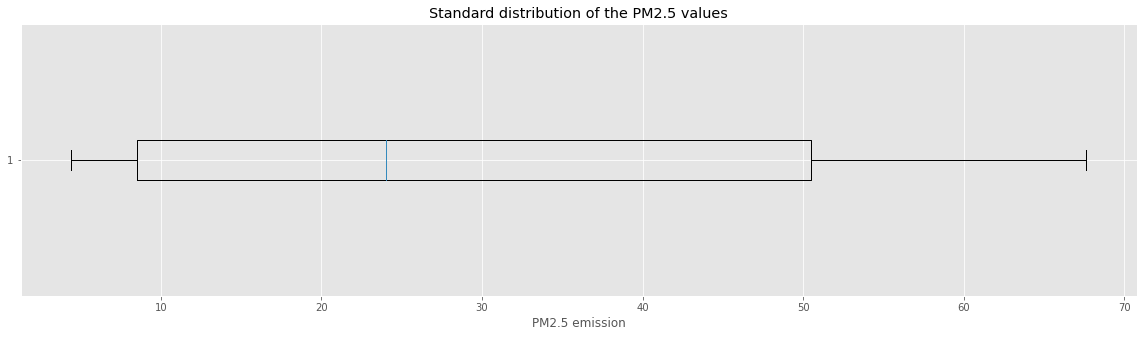

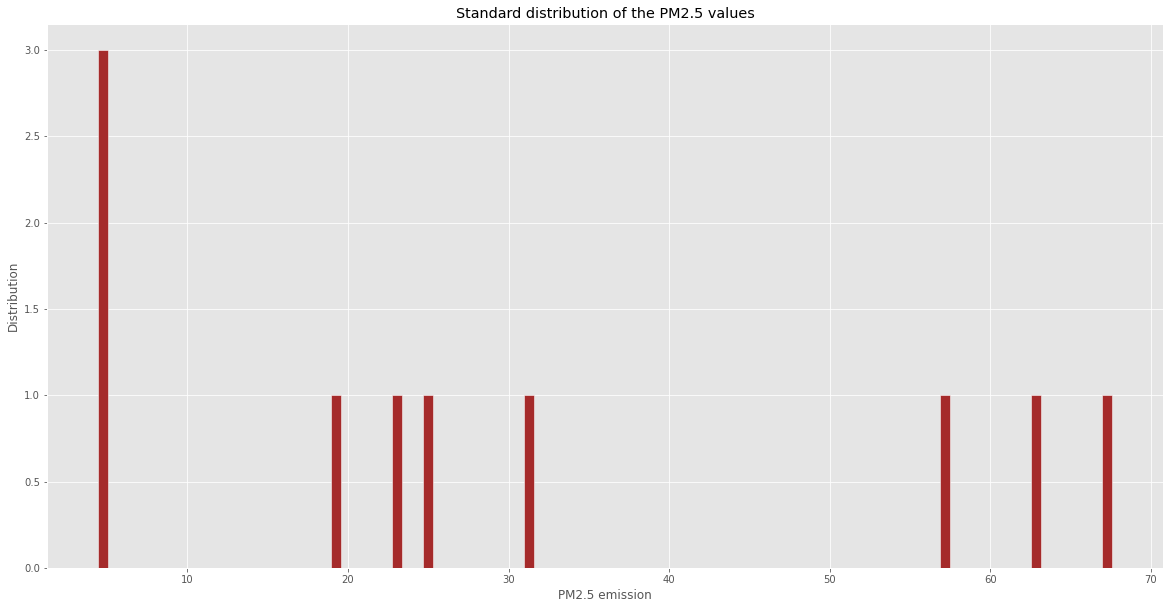

In [4]:
#Checking skewness of the dataset
print(df_ap.skew(numeric_only=True))
#Most skewed data in the dataset is the PM2.5 data
plt.figure(figsize=(20,5))
plt.boxplot( df_ap['pm2.5'], vert=False)
plt.title("Standard distribution of the PM2.5 values")
plt.xlabel("PM2.5 emission")

plt.show()
plt.figure(figsize=(20,10))
plt.hist(df_ap['pm2.5'], edgecolor='white', color='brown', bins=100)
plt.title("Standard distribution of the PM2.5 values")
plt.xlabel("PM2.5 emission")
plt.ylabel("Distribution")
plt.show()
#The distribution of the PM2.5 data has a short head and a long tail
#The tail seems to be peaking, possible anomalies

<h4><font color=brown>Correlations in the dataset</font></h4>

Pearson: 0.8623662298765173
Spearman: 0.8303030303030302


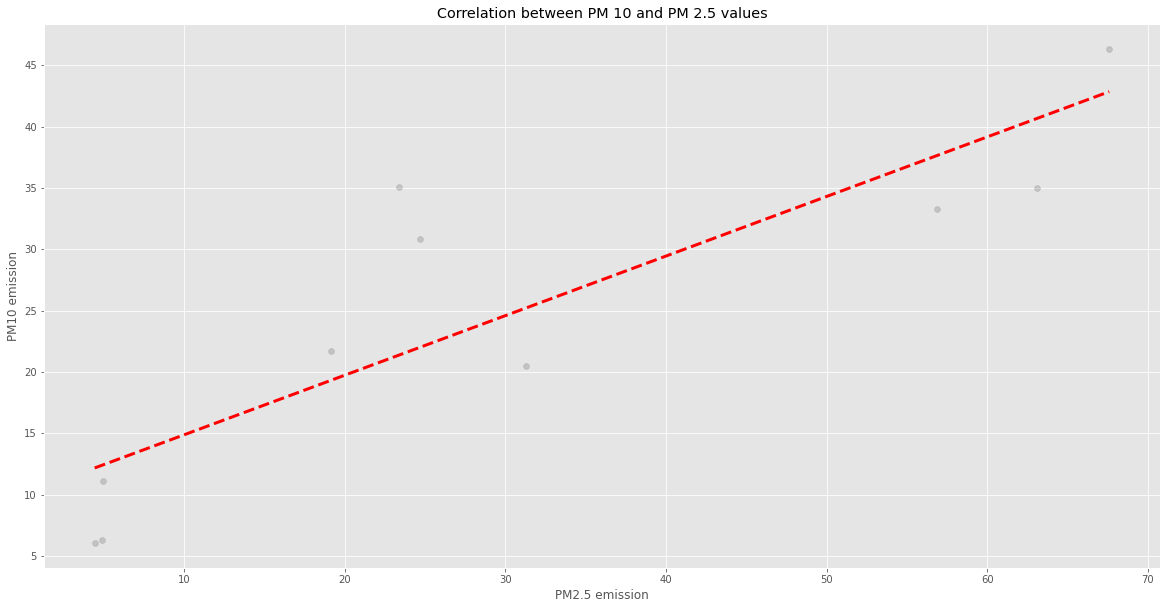

In [5]:
#Correlation matrix
print('Pearson: ' + str(df_ap['pm2.5'].corr(df_ap['pm10'], method='pearson')))
print('Spearman: ' + str(df_ap['pm2.5'].corr(df_ap['pm10'], method='spearman')))

#The highest correlation in the dataset is between PM10 and PM2.5 data 
plt.figure(figsize=(20,10))
plt.scatter(df_ap["pm2.5"], df_ap["pm10"], alpha=.15, color='black')
plt.plot(np.unique(df_ap["pm2.5"]), np.poly1d(np.polyfit(df_ap["pm2.5"], df_ap["pm10"], 1))
         (np.unique(df_ap["pm2.5"])), color='red', linewidth=3, linestyle='dashed')
plt.xlabel('PM2.5 emission')
plt.ylabel('PM10 emission')
plt.title("Correlation between PM 10 and PM 2.5 values")
plt.show()

<h4><font color=brown>Average PM2.5 per day</font></h4>

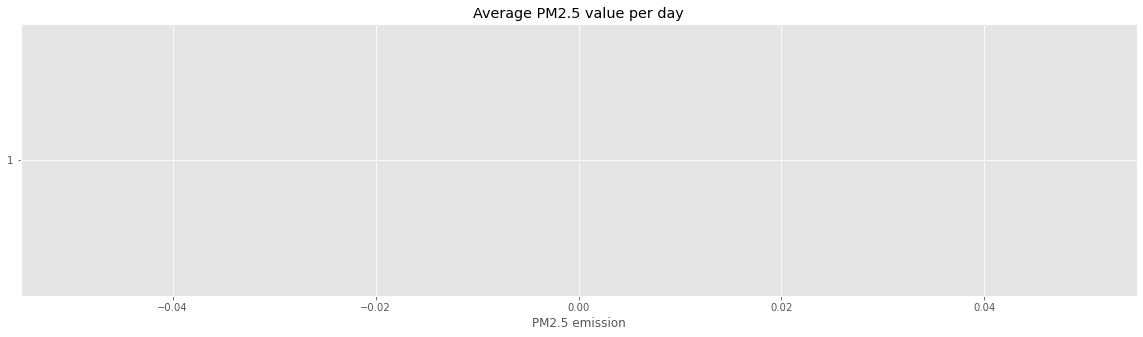

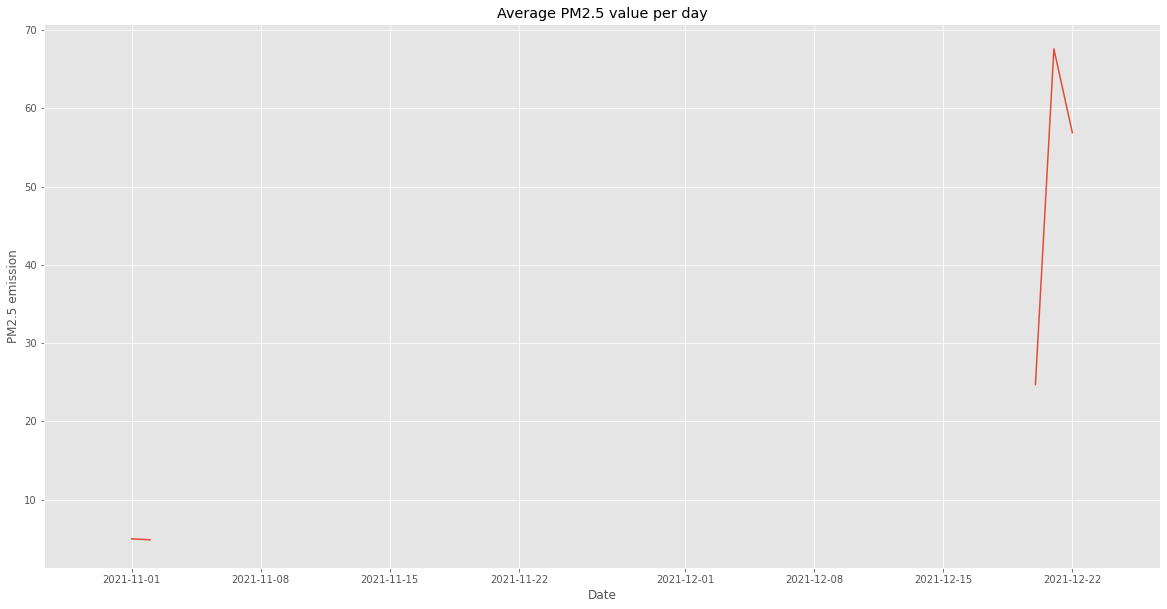

In [6]:
df_ap_day_mean = df_ap.groupby(pd.Grouper(freq='D', key='date')).mean()

plt.figure(figsize=(20,5))
plt.boxplot(df_ap_day_mean['pm2.5'], vert=False)
plt.title("Average PM2.5 value per day")
plt.xlabel("PM2.5 emission")
plt.show()

plt.figure(figsize=(20,10))
plt.title("Average PM2.5 value per day")
plt.plot(df_ap_day_mean['pm2.5'])
plt.xlabel("Date")
plt.ylabel("PM2.5 emission")
plt.show()

<h4><font color=brown> Worst sum total pollution in different postal code areas</font></h4>

Most populted areas with the polution type:


,PC4,pm10,pm2.5,no2,no,so2
0,5612,11.076507,4.968415,12.971743,8.486832,1.947815
1,5613,35.067577,23.365223,39.012191,25.523933,6.180705
2,5621,21.750656,19.151531,20.059514,13.124044,0.257145
3,5625,36.869956,29.125855,50.057872,21.739036,6.194950
4,5641,34.975610,63.075740,20.789632,0.292635,1.320864
5,5642,6.266603,4.855548,16.978822,11.108484,3.063834
6,5651,46.344620,67.599040,28.866037,23.197769,12.406485
7,5656,33.290670,56.892000,36.617145,22.172878,2.246518
8,5657,20.460490,31.281980,13.962393,0.136534,2.384445


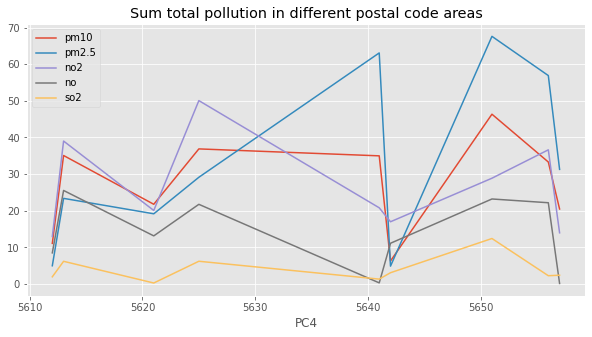

In [7]:
df_ap_sp = df_ap.groupby(['PC4']).sum(numeric_only=True)
df_ap_sp.plot(legend=True, figsize=(10,5), title="Sum total pollution in different postal code areas")

print('Most populted areas with the polution type:')
df_ap_sp = df_ap_sp.drop_duplicates()
df_ap_sp.reset_index().style.highlight_max(color = 'orange')

<h4><font color=brown> Most peak pollution in different postal code areas</font></h4>

Most polluted areas per pllution type:
pm10     5651
pm2.5    5651
no2      5613
no       5613
so2      5651
dtype: int64


,PC4,pm10,pm2.5,no2,no,so2
0,5612,11.076507,4.968415,12.971743,8.486832,1.947815
1,5613,35.067577,23.365223,39.012191,25.523933,6.180705
2,5621,21.750656,19.151531,20.059514,13.124044,0.257145
3,5625,30.821290,24.695960,28.763615,13.931881,5.508672
4,5641,34.975610,63.075740,20.789632,0.292635,1.320864
5,5642,6.266603,4.855548,16.978822,11.108484,3.063834
6,5651,46.344620,67.599040,28.866037,23.197769,12.406485
7,5656,33.290670,56.892000,36.617145,22.172878,2.246518
8,5657,20.460490,31.281980,13.962393,0.136534,2.384445


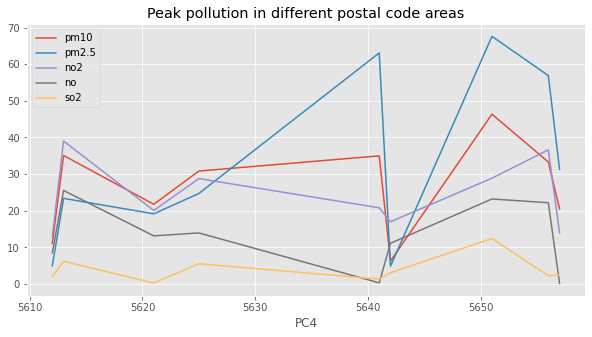

In [8]:
df_ap_mp = df_ap.groupby(['PC4']).max(numeric_only=True)
df_ap_mp.plot(legend=True, figsize=(10,5), title="Peak pollution in different postal code areas")

print('Most polluted areas per pllution type:')
#Only grabs the first value, or none
print(df_ap_mp.idxmax())

df_ap_mp = df_ap_mp.drop_duplicates()
df_ap_mp.reset_index().style.highlight_max(color = 'orange')



#The PM2.5 sensor is peaking in different areas 

<h4><font color=brown> Least pollution in different postal code areas</font></h4>

Least polluted areas per pllution type:
pm10     5625
pm2.5    5625
no2      5612
no       5657
so2      5621
dtype: int64


,PC4,pm10,pm2.5,no2,no,so2
0,5612,11.076507,4.968415,12.971743,8.486832,1.947815
1,5613,35.067577,23.365223,39.012191,25.523933,6.180705
2,5621,21.750656,19.151531,20.059514,13.124044,0.257145
3,5625,6.048666,4.429895,21.294257,7.807154,0.686278
4,5641,34.975610,63.075740,20.789632,0.292635,1.320864
5,5642,6.266603,4.855548,16.978822,11.108484,3.063834
6,5651,46.344620,67.599040,28.866037,23.197769,12.406485
7,5656,33.290670,56.892000,36.617145,22.172878,2.246518
8,5657,20.460490,31.281980,13.962393,0.136534,2.384445


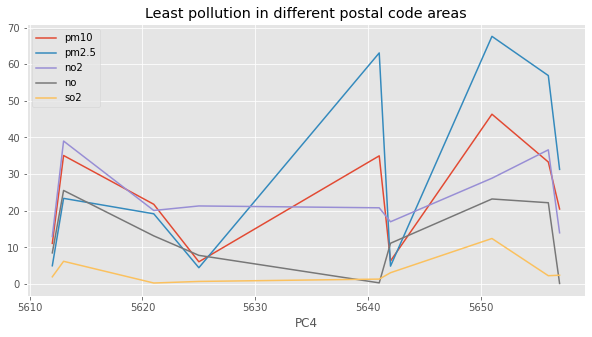

In [9]:
df_ap_lp = df_ap.groupby(['PC4']).min(numeric_only=True)
df_ap_lp.plot(legend=True, figsize=(10,5), title="Least pollution in different postal code areas")

print('Least polluted areas per pllution type:')
#Only grabs the first value, or none
print(df_ap_lp.idxmin())

df_ap_lp = df_ap_lp.drop_duplicates()
df_ap_lp.reset_index().style.highlight_min(color = 'lightgreen')

#The sulfur dioxide sensor is detecting nothing, sometimes

<h4><font color=brown>Most pluted day per pollution type, per postal code(day mean)</font></h4>

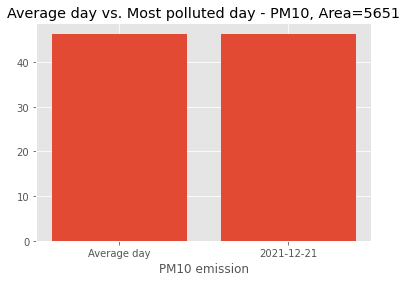

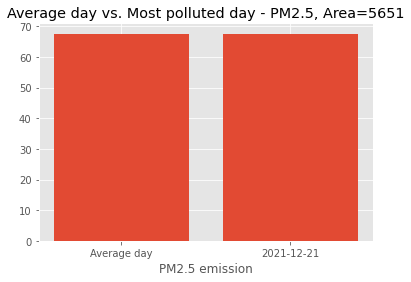

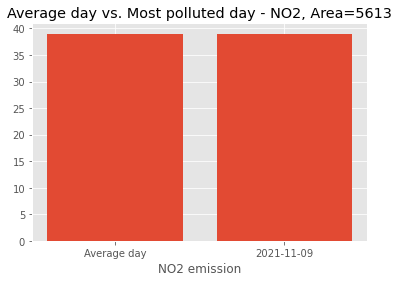

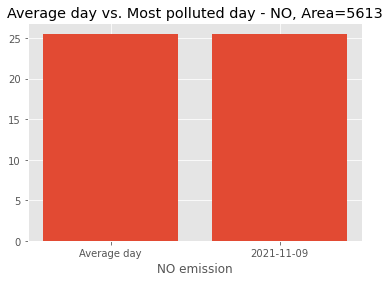

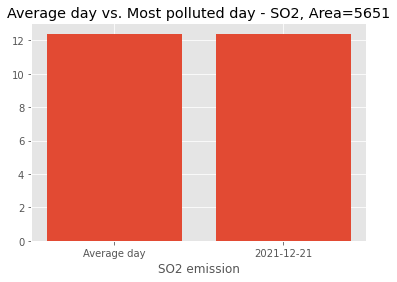

In [10]:
most_polluted_days = df_ap_per_date_per_postalcode.idxmax()

i = 0
for day in most_polluted_days:
    most_polluted_values = df_ap_per_date_per_postalcode.loc[(day[0] ,day[1]), :]
    all_for_postcode =  df_ap_per_date_per_postalcode.loc[(slice(None), day[1]), :]
    plt.bar(["Average day", str(day[0].date())], [all_for_postcode.mean()[most_polluted_days.index[i]], most_polluted_values.loc[most_polluted_days.index[i]]])
    plt.title("Average day vs. Most polluted day - " + str(most_polluted_days.index[i]).upper() + ", Area=" + str(day[1]) )
    plt.xlabel(str(most_polluted_days.index[i]).upper() + " emission")
    plt.show()
    i += 1

    
    

    

<h4><font color=brown>Least pluted day per pollution type, per postal code(day mean)</font></h4>

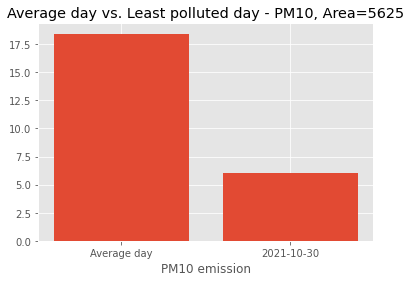

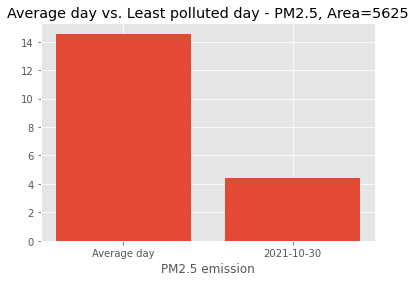

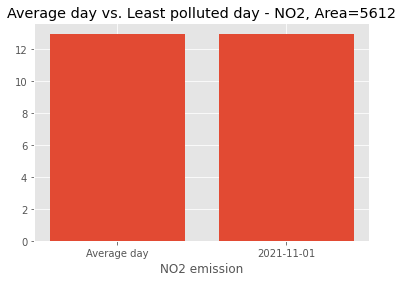

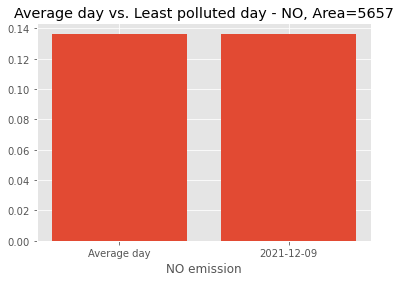

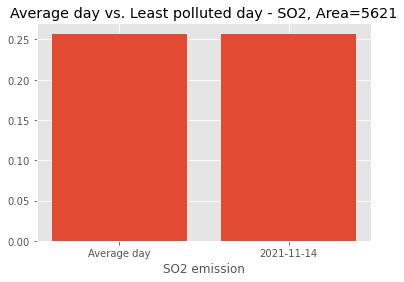

In [11]:
least_polluted_days = df_ap_per_date_per_postalcode.idxmin()

i = 0
for day in least_polluted_days:
    least_polluted_values = df_ap_per_date_per_postalcode.loc[(day[0] ,day[1]), :]
    all_for_postcode =  df_ap_per_date_per_postalcode.loc[(slice(None), day[1]), :]
    plt.bar(["Average day", str(day[0].date())], [all_for_postcode.mean()[least_polluted_days.index[i]], least_polluted_values.loc[least_polluted_days.index[i]]])
    plt.title("Average day vs. Least polluted day - " + str(least_polluted_days.index[i]).upper() + ", Area=" + str(day[1]) )
    plt.xlabel(str(least_polluted_days.index[i]).upper() + " emission")
    plt.show()
    i += 1

    
    
    


<h4><font color=brown>A deeper look at the most polluted day in the most polluted area - PM2.5</font></h4>

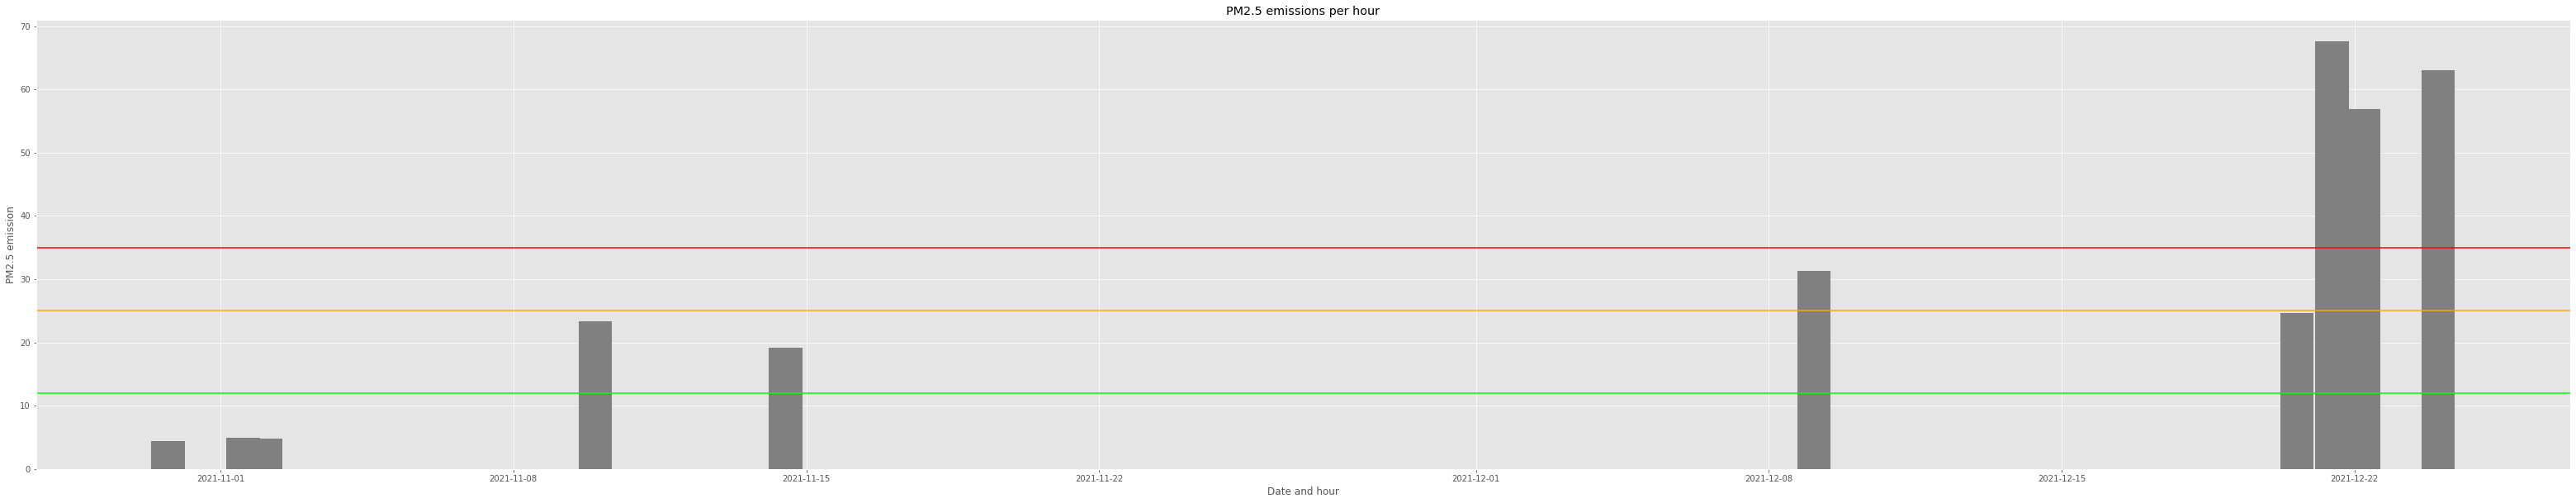

In [12]:
# DOUBLE CLICK ON THE GRAPH TO ZOOM IN #

most_polluted = df_ap_per_date_per_postalcode.idxmax()['pm2.5']
most_polluted_date = most_polluted[0].date() 
most_polluted_areacode = most_polluted[1]

START_DATE =  str(most_polluted_date + timedelta(days=-0))
END_DATE = str(most_polluted_date + timedelta(days=+3))

FIG_HEIGHT = 10
FIG_WIDTH = 55

# UNCOMMENT TO SELECT DATES #
# mask = ((df_ap['date'] > START_DATE) & (df_ap['date'] <= END_DATE) & (df_ap['PC4'] <= most_polluted_areacode))
# air_pollution = df_ap_np.loc[mask]
air_pollution = df_ap

f = plt.figure()
f.set_figheight(FIG_HEIGHT)
f.set_figwidth(FIG_WIDTH)
plt.bar(air_pollution['date'], air_pollution['pm2.5'], color='gray')
plt.title("PM2.5 emissions per hour")
plt.xlabel("Date and hour")
plt.ylabel("PM2.5 emission")

healthy_level = [12]
legal_limit = [25]
unhealthy_level = [35]

plt.axhline(y = healthy_level, color = '#00FF00', linestyle = '-')
plt.axhline(y = legal_limit, color = '#FFA500', linestyle = '-')
plt.axhline(y = unhealthy_level, color = '#FF0000', linestyle = '-')

plt.show()

<h2><font color=slateblue> 5. Data Preparation </font></h2>

<h2><font color=slateblue> 6. Modelling </font></h2>